# City initialization and methods

In [1]:
import os
import pandas as pd
import geopandas as gpd

local_crs = 32636
example_data_path = "./data"

## Initialization

Use the results obtained from the ``blocksnet.preprocessing`` or use your own data.

In [2]:
blocks = gpd.read_file(os.path.join(example_data_path, "platform/blocks_pzz.geojson"))
adjacency_matrix = pd.read_pickle(os.path.join(example_data_path, "adjacency_matrix.pickle"))

In [3]:
from blocksnet.models import City

city_model = City(
  blocks=blocks.rename(columns={'landuse_1':'land_use'}), 
  adj_mx=adjacency_matrix, 
) 

Print city model to get the information about existing service types, CRS and blocks count

In [4]:
print(city_model)

CRS : EPSG:32636
Blocks : 3839
Service types : 43
Buildings : 0
Services : 0



## Update layers

Update the information about services and buildings using ``.update_buildings()`` and ``.update_services()``.

It is **IMPORTANT** to update buildings first, because they serve as container for some kinds of services.

Specification for buildings is described in the ``blocksnet.models.city.Building``

In [5]:
buildings = gpd.read_parquet(os.path.join(example_data_path, "platform/buildings.parquet")).to_crs(local_crs)

In [6]:
buildings = buildings.rename(columns={
  'population_balanced': 'population',
  'building_area': 'footprint_area',
})
buildings = buildings.fillna(0)
buildings['number_of_floors'] = buildings.apply(
  lambda x : x['storeys_count'] if x['storeys_count']>1 else 1, 
  axis=1
)
buildings['build_floor_area'] = buildings['footprint_area']*buildings['number_of_floors']
buildings['business_area'] = buildings['build_floor_area'] - buildings['living_area']

In [7]:
city_model.update_buildings(buildings)

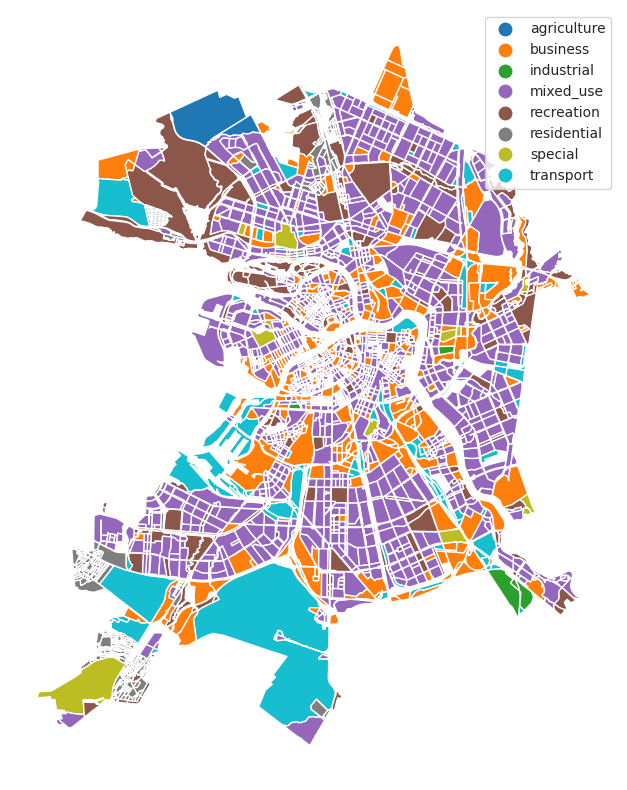

In [8]:
city_model.get_blocks_gdf().plot(column='land_use', figsize=(10,10), legend=True).set_axis_off()

Specification is described in the ``blocksnet.models.city.Service``

In [9]:
for service_type in city_model.service_types:
  print(service_type.name)
  try:
    services_gdf = gpd.read_parquet(os.path.join(example_data_path, f"platform/{service_type.name}.parquet"))
    city_model.update_services(service_type, services_gdf.to_crs(city_model.crs))
  except:
    print(f'some problems with {service_type.name}')

school
kindergarten
some problems with kindergarten
hospital
some problems with hospital
polyclinic
pitch
some problems with pitch
swimming_pool
some problems with swimming_pool
stadium
some problems with stadium
theatre
museum
some problems with museum
cinema
some problems with cinema
mall
some problems with mall
convenience
some problems with convenience
supermarket
some problems with supermarket
cemetery
some problems with cemetery
religion
some problems with religion
market
some problems with market
bowling_alley
some problems with bowling_alley
university
some problems with university
playground
some problems with playground
pharmacy
some problems with pharmacy
fuel
some problems with fuel
beach
some problems with beach
train_building
some problems with train_building
bank
some problems with bank
lawyer
some problems with lawyer
cafe
some problems with cafe
subway_entrance
some problems with subway_entrance
multifunctional_center
hairdresser
some problems with hairdresser
restaura

Upload landuse file for existing blocks to update ``LandUse`` according to ``blocksnet.models.city.LandUseRow``

In [10]:
block = city_model[2]
res = block.to_dict()
for key,value in res.items():
  if isinstance(value, float) : res[key]=round(res[key],2)
res

{'id': 2,
 'geometry': <POLYGON ((349119.898 6656201.093, 349137.911 6656195.272, 349139.322 665617...>,
 'land_use': 'mixed_use',
 'is_living': True,
 'build_floor_area': 143972.4,
 'living_demand': 23.81,
 'living_area': 96196.7,
 'share_living': 5.17,
 'business_area': 47775.7,
 'share_business': 2.57,
 'site_area': 113131.65,
 'population': 4040,
 'footprint_area': 18603.42,
 'fsi': 1.27,
 'gsi': 0.16,
 'l': 7.74,
 'osr': 0.66,
 'capacity_kindergarten': 280}

In [11]:
city_model.to_pickle('new_model.pickle')

In [46]:
lu = gpd.read_file(os.path.join(example_data_path, "landuse.geojson"))
city_model.update_land_use(lu)

AttributeError: 'City' object has no attribute 'update_land_use'

## Methods and other ways to operate the ``City`` model

Plot city model layers with `.plot()`

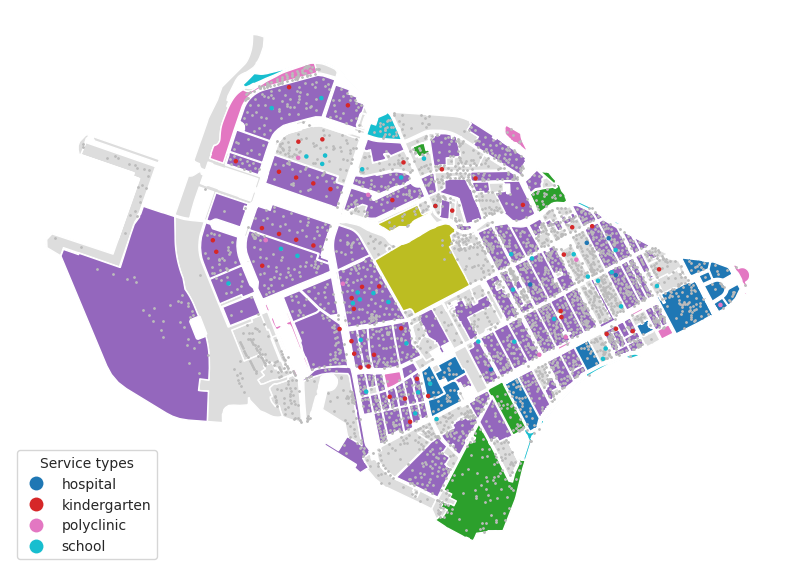

In [ ]:
city_model.plot()

Save city model to file with ``.to_pickle()`` so we can use it later

In [ ]:
city_model.to_pickle(os.path.join(example_data_path, 'city_model.pickle'))

``Block`` within the city model can be obtained via ``id`` (int)

In [ ]:
block = city_model[123]
block

Block(id=123, geometry=<POLYGON ((346460.223 6649125.497, 346465.461 6649128.123, 346465.462 664912...>, land_use=<LandUse.MIXED_USE: 'mixed_use'>, buildings=None, services={}, city=<blocksnet.models.city.City object at 0x7f12698ac670>)

Get available ``ServiceType``s for current ``Block`` ``LandUse``

In [ ]:
available_service_types = block.land_use_service_types
[st.name for st in available_service_types]

['school',
 'kindergarten',
 'hospital',
 'polyclinic',
 'pitch',
 'swimming_pool',
 'stadium',
 'theatre',
 'museum',
 'cinema',
 'mall',
 'convenience',
 'supermarket',
 'religion',
 'marketplace',
 'bowling_alley',
 'bank',
 'lawyer',
 'cafe',
 'subway_entrance',
 'hairdresser',
 'restaurant',
 'bar_pub',
 'hotel',
 'post',
 'police']

``ServiceType`` can be obtained the same way by ``name`` (str). The information about accessibility, demand, bricks can be obtained this way.

In [ ]:
service_type = city_model['school']
service_type

ServiceType(code='3.5.1', name='school', accessibility=15, demand=120, bricks=[ServiceBrick(capacity=250, area=1.2, is_integrated=False, parking_area=0.0), ServiceBrick(capacity=300, area=1.1, is_integrated=False, parking_area=0.0), ServiceBrick(capacity=600, area=1.3, is_integrated=False, parking_area=0.0), ServiceBrick(capacity=1100, area=1.8, is_integrated=False, parking_area=0.0), ServiceBrick(capacity=250, area=0.2, is_integrated=True, parking_area=0.02), ServiceBrick(capacity=300, area=0.36, is_integrated=True, parking_area=0.03), ServiceBrick(capacity=600, area=0.8, is_integrated=True, parking_area=0.06), ServiceBrick(capacity=1100, area=1.1, is_integrated=True, parking_area=0.1)], land_use=[<LandUse.RESIDENTIAL: 'residential'>, <LandUse.MIXED_USE: 'mixed_use'>, <LandUse.BUSINESS: 'business'>])

Add new ``ServiceType`` to the ``City`` model list

In [ ]:
from blocksnet import ServiceType

city_model.add_service_type(ServiceType(code='', name='bakeries', accessibility=30, demand=100, bricks=[]))
city_model['bakeries']

ServiceType(code='', name='bakeries', accessibility=30, demand=100, bricks=[])

Get the distance (min) between two city ``Block``s

In [ ]:
city_model.get_distance(0, 1)

9.1

Get blocks ``GeoDataFrame`` via ``.get_blocks_gdf()`` method

In [ ]:
blocks_gdf = city_model.get_blocks_gdf()
blocks_gdf.head()

,geometry
id,
0,"POLYGON ((345370.504 6646430.885, 345370.505 6..."
1,"POLYGON ((345254.667 6647047.217, 345254.667 6..."
2,"POLYGON ((345055.642 6646758.330, 345055.643 6..."
3,"POLYGON ((344966.092 6647146.023, 344966.091 6..."
4,"POLYGON ((345082.562 6646776.418, 345082.561 6..."


The same way buildings and services ``GeoDataFrame``s can be obtained with:

- ``.get_buildings_gdf()``
- ``.get_services_gdf()``

In [ ]:
buildings_gdf = city_model.get_buildings_gdf()
buildings_gdf.head()

,geometry,population,floors,area,living_area,is_living
0,POINT (345625.313 6646379.081),0.0,0.0,0.0000,0.0,False
1,POINT (345639.028 6646409.751),0.0,1.0,575.4110,0.0,False
2,POINT (345619.009 6646431.188),0.0,1.0,284.8310,0.0,False
3,POINT (345638.596 6646459.785),0.0,1.0,16.2936,0.0,False
4,POINT (345452.265 6646403.874),0.0,7.0,51867.5500,0.0,False


In [ ]:
services_gdf = city_model.get_services_gdf()
services_gdf.head()

,geometry,capacity,service_type
0,POINT (344241.473 6648149.216),1200,school
1,POINT (344950.101 6648432.999),1244,school
2,POINT (344780.761 6648505.608),1200,school
3,POINT (345204.730 6649377.764),1200,school
4,POINT (345042.090 6649454.563),1200,school
